In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data: Covtype Dataset

In [3]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [4]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [5]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [6]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


## Deterministic Gradient Free Frank Wolfe on Covtype

In [7]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=5)

Loss evaluation at time 1:	0.7013836

Loss evaluation at time 2:	0.1212442

Loss evaluation at time 3:	0.0424383

Loss evaluation at time 4:	0.0199207

Loss evaluation at time 5:	0.0109946

CPU times: user 17.6 s, sys: 906 ms, total: 18.5 s
Wall time: 11.2 s


In [8]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.34641199738781203

F(w) = 0.3354173784042209

w = [0.         0.         0.         0.         0.         0.
 0.         0.95238095 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

average w = [0.         0.         0.         0.         0.         0.
 0.         0.85714286 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [9]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)

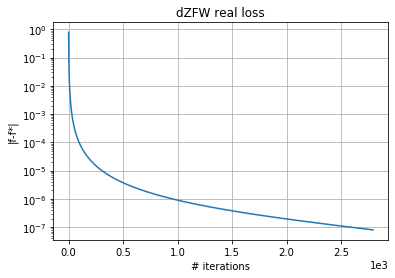

In [10]:
F_evald = np.abs(f_d - f_star)
plt.plot(F_evald[:-2000])
plt.yscale("log")
plt.title("dZFW real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

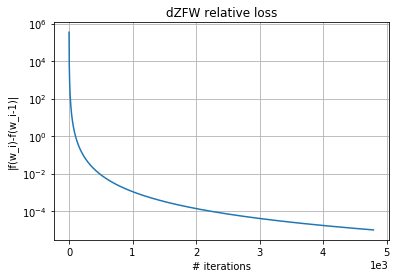

In [11]:
plt.plot(lossd)
plt.yscale("log")
plt.title("dZFW relative loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.grid()

## Stochastic Gradient Free Frank Wolfe on Covtype

In [12]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA1", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0275749

Loss evaluation at time 2:	0.0056888

Loss evaluation at time 3:	0.2195518

Loss evaluation at time 4:	0.0789956

Loss evaluation at time 5:	0.0358417

Loss evaluation at time 6:	0.1041304

Loss evaluation at time 7:	0.0282238

Loss evaluation at time 8:	0.0458985

Loss evaluation at time 9:	0.0664736

Loss evaluation at time 10:	0.0526058

CPU times: user 5.3 s, sys: 296 ms, total: 5.59 s
Wall time: 3.55 s


In [13]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.  

In [14]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

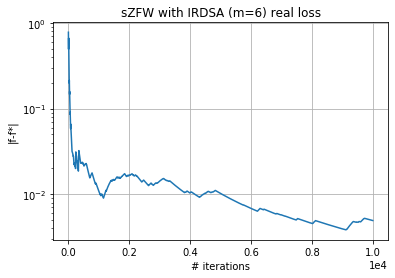

In [15]:
F_evalsm6 = np.abs(f_stochm6 - f_star)
plt.plot(F_evalsm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

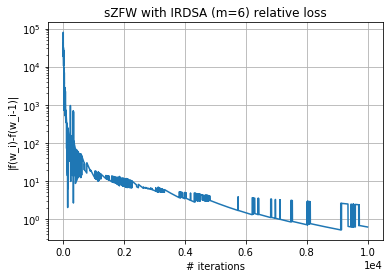

In [16]:
plt.plot(loss_stochm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

In [17]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

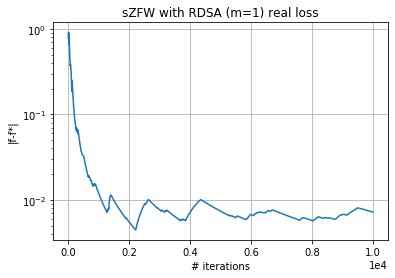

In [18]:
F_evalsm1 = np.abs(f_stochm1 - f_star)
plt.plot(F_evalsm1)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1) real loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.grid()

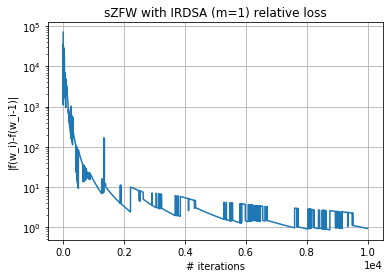

In [19]:
plt.plot(loss_stochm1)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=1) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates on Covtype

In [20]:
# setting parameters
L = 3
D = 20 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100)
B = 1

In [21]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 2, eps = 1e-8)

Loss evaluation at time 1:	0.0000000

CPU times: user 4.95 s, sys: 1.01 s, total: 5.96 s
Wall time: 3.57 s


In [22]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 1.2313988351359353

F(w) = 1.2313988351359353

w = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

average w = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

T = 1


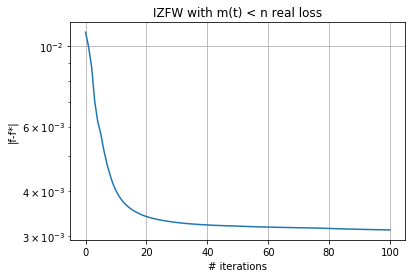

In [53]:
f_inex = np.load('../Data/results/function_IZFW_lasso_long.npy') # data from cluster
loss_inex = np.load('../Data/results/loss_IZFW_lasso_long.npy')
inner_inex = np.load('../Data/results/inner_IZFW_lasso_long.npy')
F_eval_inex = np.abs(f_inex/n - f_star)
plt.plot(F_eval_inex)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < n real loss")
plt.xlabel("# iterations")
plt.grid()

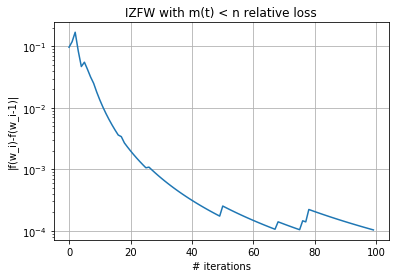

In [54]:
plt.plot(loss_inex)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < n relative loss")
plt.xlabel("# iterations")
plt.grid()

## Result Comparison on Covtype


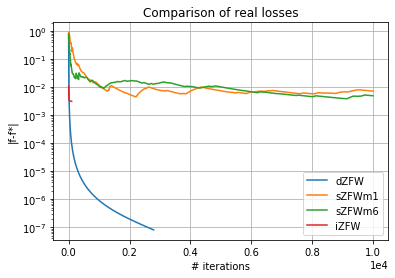

In [82]:
plt.plot(F_evald[:-2000])
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.grid()

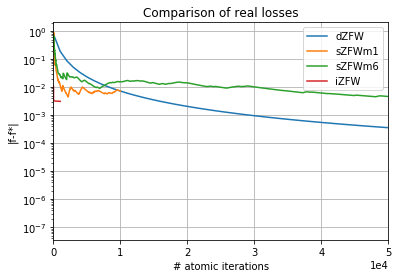

In [80]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, len(F_evald)*d, d)[:-2000], F_evald[:-2000])
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([m(t)+inner_inex[t] for t in range(101)], F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,50000))
plt.grid()

In [57]:
inner_inex

array([ 0, 17, 21, 21, 14, 12,  7, 12,  7, 10,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  5,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  5,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

# Load data: artificial dataset


In [27]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [28]:
X, y, w_star, noise = CreateDataSet(n = 100, d = 1000, s = 0.05)

In [29]:
np.sum(np.abs(w_star))

1.0

In [30]:
# space dimension
d = X.shape[1]
n = y.shape[0]
f_star = F(w_star)
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")
print(f"f* = {f_star:.8f}")

Space Dimensions
d: 1000
n: 100
f* = 0.00001625


In [31]:
# initialize parameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = int(d/2))
w0[indeces] = int(0)
print(f"w0: {w0[:10]}, {np.count_nonzero(w0)} elements different from zero")

w0: [0.00000000e+00 6.94725184e-05 5.32349094e-07 6.23650766e-05
 0.00000000e+00 2.30543109e-05 0.00000000e+00 4.58801767e-05
 6.46670184e-05 0.00000000e+00], 595 elements different from zero


## Deterministic Gradient Free Frank Wolfe on Artificial Dataset

In [32]:
# Lipshitz constant 
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)
print(L)

208.62395959442188


In [33]:
%%time

# Lipschitz constant 

fpred, f, w, mean, t, loss, f_valuesd = detZFW(F, L, d, w0, T=1000, eps = 1e-8)

Loss evaluation at time 1:	0.2869688

Loss evaluation at time 2:	0.2624069

Loss evaluation at time 3:	0.0283229

Loss evaluation at time 4:	0.0363124

Loss evaluation at time 5:	0.0025483

Loss evaluation at time 6:	0.0077457

Loss evaluation at time 7:	0.0023958

Loss evaluation at time 8:	0.0006643

Loss evaluation at time 9:	0.0035124

Loss evaluation at time 10:	0.0015967

Loss evaluation at time 11:	0.0036494

Loss evaluation at time 12:	0.0023726

Loss evaluation at time 13:	0.0035014

Loss evaluation at time 14:	0.0010940

Loss evaluation at time 15:	0.0018221

Loss evaluation at time 16:	0.0000485

Loss evaluation at time 17:	0.0014287

Loss evaluation at time 18:	0.0023645

Loss evaluation at time 19:	0.0007307

Loss evaluation at time 20:	0.0011386

Loss evaluation at time 21:	0.0002368

Loss evaluation at time 22:	0.0005389

Loss evaluation at time 23:	0.0001284

Loss evaluation at time 24:	0.0002807

Loss evaluation at time 25:	0.0003878

Loss evaluation at time 26:	0.0004

Loss evaluation at time 210:	0.0000016

Loss evaluation at time 211:	0.0000036

Loss evaluation at time 212:	0.0000067

Loss evaluation at time 213:	0.0000238

Loss evaluation at time 214:	0.0000040

Loss evaluation at time 215:	0.0000133

Loss evaluation at time 216:	0.0000115

Loss evaluation at time 217:	0.0000009

Loss evaluation at time 218:	0.0000012

Loss evaluation at time 219:	0.0000008

Loss evaluation at time 220:	0.0000127

Loss evaluation at time 221:	0.0000132

Loss evaluation at time 222:	0.0000017

Loss evaluation at time 223:	0.0000057

Loss evaluation at time 224:	0.0000051

Loss evaluation at time 225:	0.0000016

Loss evaluation at time 226:	0.0000001

Loss evaluation at time 227:	0.0000018

Loss evaluation at time 228:	0.0000019

Loss evaluation at time 229:	0.0000194

Loss evaluation at time 230:	0.0000032

Loss evaluation at time 231:	0.0000079

Loss evaluation at time 232:	0.0000040

Loss evaluation at time 233:	0.0000155

Loss evaluation at time 234:	0.0000089



In [34]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376756

F(w_pred) = 0.00015722185392171386

F(w) = 0.00015722510307105127

w = [ 0.00000000e+00  2.19669002e-09  1.68326407e-11  1.97195588e-09
  0.00000000e+00  6.60848742e-03  0.00000000e+00  1.45071070e-09
  3.69948981e-03  0.00000000e+00  0.00000000e+00  4.74515930e-10
  7.92202773e-10  1.42048216e-09  2.24498830e-03  2.63663869e-09
  2.16029669e-09  0.00000000e+00  0.00000000e+00  9.68511210e-10
  0.00000000e+00  7.27249923e-03  0.00000000e+00  2.29969919e-10
  2.68046521e-09  2.71493511e-09  1.97556516e-09  4.74539905e-10
 -2.08688928e-03 -5.47018276e-03  0.00000000e+00 -2.44419149e-02
  0.00000000e+00  1.36442998e-09 -4.64807437e-03  0.00000000e+00
 -2.40624782e-02  2.54195325e-10  1.46595254e-09 -4.90103080e-03
  0.00000000e+00  2.70281978e-09 -3.41491178e-03  6.71313771e-10
 -6.98792133e-03  0.00000000e+00 -1.07190286e-02  2.33145447e-09
  1.47518269e-09  1.43269332e-10  0.00000000e+00 -7.11439890e-03
  0.00000000e+00  2.30688825e-09  2.00583715e

In [35]:
loss_ad = np.load("../Data/results/loss_dZFW_lasso_AD.npy")
f_valuesd = np.load("../Data/results/function_dZFW_lasso_AD.npy")

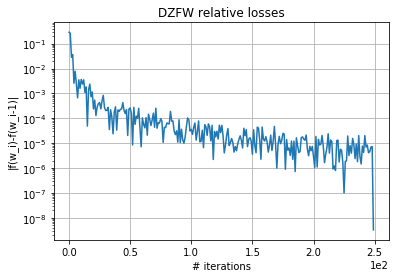

In [36]:
plt.plot(loss_ad)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title("DZFW relative losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.xlabel("# iterations")
plt.grid()

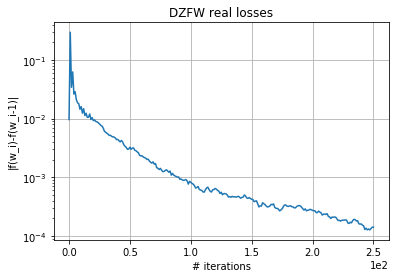

In [37]:
plt.plot(f_valuesd - f_star)
plt.yscale("log")
plt.title("DZFW real losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

## Stochastic Gradient Free Frank Wolfe on Artificial Dataset

In [38]:
%%time
fpred, f, w, mean, t, loss, f_valuess = stochasticZFW(F, d, w0, method = "IRDSA2", r=1, T=1000, eps=1e-8)

Loss evaluation at time 1:	0.0235488

Loss evaluation at time 2:	0.0041638

Loss evaluation at time 3:	0.0074961

Loss evaluation at time 4:	0.0013408

Loss evaluation at time 5:	0.0002935

Loss evaluation at time 6:	0.0048255

Loss evaluation at time 7:	0.0039489

Loss evaluation at time 8:	0.0150047

Loss evaluation at time 9:	0.0124152

Loss evaluation at time 10:	0.0033470

Loss evaluation at time 11:	0.0008387

Loss evaluation at time 12:	0.0035966

Loss evaluation at time 13:	0.0020358

Loss evaluation at time 14:	0.0036083

Loss evaluation at time 15:	0.0030197

Loss evaluation at time 16:	0.0032500

Loss evaluation at time 17:	0.0001852

Loss evaluation at time 18:	0.0025119

Loss evaluation at time 19:	0.0028779

Loss evaluation at time 20:	0.0020760

Loss evaluation at time 21:	0.0026222

Loss evaluation at time 22:	0.0013292

Loss evaluation at time 23:	0.0040031

Loss evaluation at time 24:	0.0026456

Loss evaluation at time 25:	0.0023385

Loss evaluation at time 26:	0.0004

Loss evaluation at time 220:	0.0000358

Loss evaluation at time 221:	0.0000756

Loss evaluation at time 222:	0.0000064

Loss evaluation at time 223:	0.0000767

Loss evaluation at time 224:	0.0000027

Loss evaluation at time 225:	0.0000684

Loss evaluation at time 226:	0.0001369

Loss evaluation at time 227:	0.0000003

Loss evaluation at time 228:	0.0000808

Loss evaluation at time 229:	0.0000928

Loss evaluation at time 230:	0.0001428

Loss evaluation at time 231:	0.0000843

Loss evaluation at time 232:	0.0000259

Loss evaluation at time 233:	0.0000243

Loss evaluation at time 234:	0.0000295

Loss evaluation at time 235:	0.0000478

Loss evaluation at time 236:	0.0000018

Loss evaluation at time 237:	0.0000099

Loss evaluation at time 238:	0.0000499

Loss evaluation at time 239:	0.0000537

Loss evaluation at time 240:	0.0001331

Loss evaluation at time 241:	0.0000473

Loss evaluation at time 242:	0.0000598

Loss evaluation at time 243:	0.0000149

Loss evaluation at time 244:	0.0000408



Loss evaluation at time 429:	0.0000030

Loss evaluation at time 430:	0.0000349

Loss evaluation at time 431:	0.0000175

Loss evaluation at time 432:	0.0000228

Loss evaluation at time 433:	0.0000209

Loss evaluation at time 434:	0.0000026

Loss evaluation at time 435:	0.0000041

Loss evaluation at time 436:	0.0000217

Loss evaluation at time 437:	0.0000104

Loss evaluation at time 438:	0.0000105

Loss evaluation at time 439:	0.0000296

Loss evaluation at time 440:	0.0000089

Loss evaluation at time 441:	0.0000107

Loss evaluation at time 442:	0.0000300

Loss evaluation at time 443:	0.0000396

Loss evaluation at time 444:	0.0000023

Loss evaluation at time 445:	0.0000213

Loss evaluation at time 446:	0.0000312

Loss evaluation at time 447:	0.0000052

Loss evaluation at time 448:	0.0000389

Loss evaluation at time 449:	0.0000244

Loss evaluation at time 450:	0.0000055

Loss evaluation at time 451:	0.0000147

Loss evaluation at time 452:	0.0000345

Loss evaluation at time 453:	0.0000539



Loss evaluation at time 637:	0.0000158

Loss evaluation at time 638:	0.0000077

Loss evaluation at time 639:	0.0000002

Loss evaluation at time 640:	0.0000067

Loss evaluation at time 641:	0.0000039

Loss evaluation at time 642:	0.0000143

Loss evaluation at time 643:	0.0000029

Loss evaluation at time 644:	0.0000063

Loss evaluation at time 645:	0.0000237

Loss evaluation at time 646:	0.0000125

Loss evaluation at time 647:	0.0000014

Loss evaluation at time 648:	0.0000264

Loss evaluation at time 649:	0.0000096

Loss evaluation at time 650:	0.0000204

Loss evaluation at time 651:	0.0000175

Loss evaluation at time 652:	0.0000088

Loss evaluation at time 653:	0.0000002

Loss evaluation at time 654:	0.0000082

Loss evaluation at time 655:	0.0000166

Loss evaluation at time 656:	0.0000248

Loss evaluation at time 657:	0.0000178

Loss evaluation at time 658:	0.0000063

Loss evaluation at time 659:	0.0000200

Loss evaluation at time 660:	0.0000106

Loss evaluation at time 661:	0.0000016



Loss evaluation at time 844:	0.0000036

Loss evaluation at time 845:	0.0000098

Loss evaluation at time 846:	0.0000158

Loss evaluation at time 847:	0.0000218

Loss evaluation at time 848:	0.0000277

Loss evaluation at time 849:	0.0000156

Loss evaluation at time 850:	0.0000028

Loss evaluation at time 851:	0.0000076

Loss evaluation at time 852:	0.0000122

Loss evaluation at time 853:	0.0000069

Loss evaluation at time 854:	0.0000002

Loss evaluation at time 855:	0.0000011

Loss evaluation at time 856:	0.0000071

Loss evaluation at time 857:	0.0000141

Loss evaluation at time 858:	0.0000210

Loss evaluation at time 859:	0.0000070

Loss evaluation at time 860:	0.0000003

Loss evaluation at time 861:	0.0000093

Loss evaluation at time 862:	0.0000050

Loss evaluation at time 863:	0.0000062

Loss evaluation at time 864:	0.0000127

Loss evaluation at time 865:	0.0000126

Loss evaluation at time 866:	0.0000074

Loss evaluation at time 867:	0.0000080

Loss evaluation at time 868:	0.0000018



In [39]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376756

F(w_pred) = 0.0004891270654847368

F(w) = 0.000485626068705726

w = [ 7.16413676e-03  3.83275507e-09  1.83438158e-03  3.44064198e-09
  0.00000000e+00  6.56122708e-04  0.00000000e+00  2.53118044e-09
  3.56763866e-09  4.91401460e-03 -6.99468798e-04  8.27928987e-10
  1.38222470e-09  5.98193845e-03  0.00000000e+00  6.97503064e-04
  1.68069922e-03  0.00000000e+00  6.02922400e-04  1.68984528e-09
  0.00000000e+00  7.01833534e-03  0.00000000e+00 -2.22647413e-04
  1.86197091e-03  4.73698212e-09 -9.45726159e-05  8.27970818e-10
  2.19463447e-09  0.00000000e+00 -6.67155310e-03 -1.49745433e-03
  0.00000000e+00  2.38063900e-09 -2.00777100e-03  0.00000000e+00
 -1.85014066e-03  4.43516570e-10 -1.69054456e-03 -2.94762062e-03
  0.00000000e+00  4.71584346e-09 -8.72858246e-04  1.17129920e-09
 -1.11067764e-02  0.00000000e+00  0.00000000e+00  4.06789028e-09
  2.57387884e-09  2.49974395e-10  6.33659621e-03 -7.30993022e-04
  0.00000000e+00  1.39897785e-04  3.49975757e-09

In [40]:
loss_sad = np.load("../Data/results/loss_SZFW_lasso_AD.npy")
f_valuess = np.load("../Data/results/function_SZFW_lasso_AD.npy")

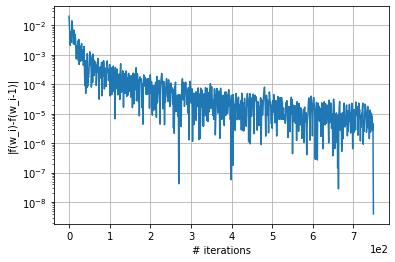

In [41]:
plt.plot(loss_sad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

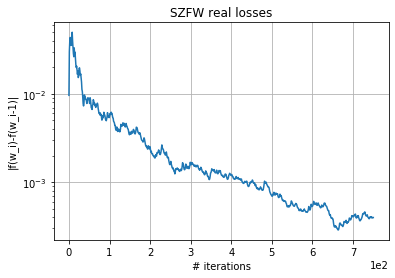

In [42]:
plt.plot(f_valuess - f_star)
plt.yscale("log")
plt.title("SZFW real losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates on Artificial Dataset

In [45]:
# setting parameters: UPDATE WITH THE FINAL ONES
B = 1 
L = 0.1
D = 10000

In [46]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 5, eps = 1e-8)


'''
with max iter = 100, m(101) = 1034

F(w_pred) = 0.01524209692890398

F(w) = 0.01502719283827

w = ***too long***

average w = ***too long***

T = 100
0.009651865274889974 0.01502719283827

--------------------------------------

with max iter = 1000, m(1001) = 100602

***Add .res***
'''

Loss evaluation at time 1:	0.0304269

Loss evaluation at time 2:	0.0060638

Loss evaluation at time 3:	0.0091177

Loss evaluation at time 4:	0.0007552

Loss evaluation at time 5:	0.0070646

CPU times: user 10.2 s, sys: 894 ms, total: 11.1 s
Wall time: 6.82 s


'\nwith max iter = 100, m(101) = 1034\n\nF(w_pred) = 0.01524209692890398\n\nF(w) = 0.01502719283827\n\nw = ***too long***\n\naverage w = ***too long***\n\nT = 100\n0.009651865274889974 0.01502719283827\n\n--------------------------------------\n\nwith max iter = 1000, m(1001) = 100602\n\n***Add .res***\n'

In [63]:
loss_i = np.load("../Data/results/loss_IZFW_AD_long.npy")
f_i = np.load("../Data/results/function_IZFW_AD_long.npy")
inner_i = np.load("../Data/results/inner_IZFW_AD_long.npy")

In [51]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 0.025659941666289925

F(w) = 0.018595341793289106

w = [ 0.00000000e+00  3.30821516e-06  2.53499568e-08  2.96976555e-06
  0.00000000e+00  1.09782433e-06  0.00000000e+00  2.18477032e-06
  3.07938183e-06  1.14285714e-01  0.00000000e+00  7.14620991e-07
  1.19305738e-06  2.13924613e-06  0.00000000e+00  3.97077787e-06
  3.25340682e-06  0.00000000e+00  0.00000000e+00  1.45857788e-06
  0.00000000e+00  2.88816726e-06  0.00000000e+00  3.46334698e-07
  4.03678060e-06  4.08869228e-06  2.97520112e-06  7.14657097e-07
  1.89428307e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.05483155e-06  0.00000000e+00  0.00000000e+00
  3.08238832e-06  3.82818159e-07  2.20772452e-06  0.00000000e+00
  0.00000000e+00  4.07044659e-06  0.00000000e+00  1.01099854e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.51117044e-06
  2.22162514e-06  2.15763613e-07  0.00000000e+00  9.75367850e-07
  0.00000000e+00  3.47417370e-06  3.02079075e-06  1.00053905e-06
  9.19695572e-

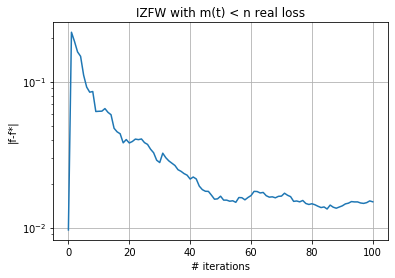

In [60]:
F_eval_i = np.abs(f_i - f_star)
plt.plot(F_eval_i)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < n real loss")
plt.xlabel("# iterations")
plt.grid()

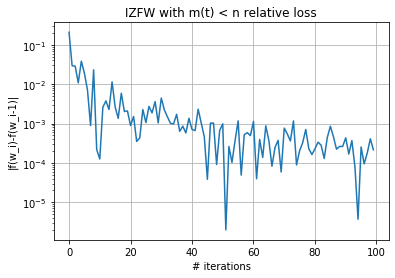

In [61]:
plt.plot(loss_i)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < n relative loss")
plt.xlabel("# iterations")
plt.grid()

In [65]:
loss_i1000 = np.load("../Data/results/loss_IZFW_AD_long_1000.npy")
f_i1000 = np.load("../Data/results/function_IZFW_AD_long_1000.npy")
inner_i1000 = np.load("../Data/results/inner_IZFW_AD_long_1000.npy")

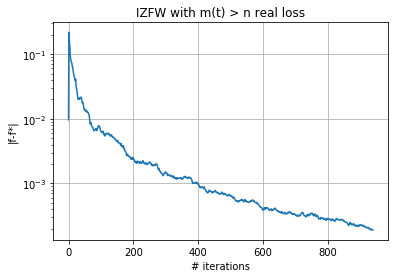

In [66]:
F_eval_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_eval_i1000)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) > n real loss")
plt.xlabel("# iterations")
plt.grid()

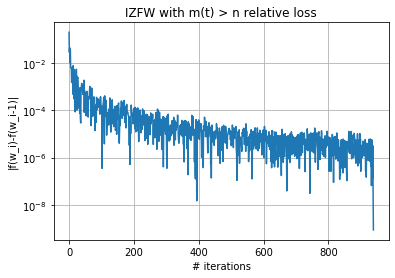

In [67]:
plt.plot(loss_i1000)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) > n relative loss")
plt.xlabel("# iterations")
plt.grid()

## Comparisons among all methods on Artificial Dataset

In [93]:
F_d = np.abs(f_valuesd - f_star)
F_s = np.abs(f_valuess - f_star)
F_i = np.abs(f_i - f_star)
F_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_d)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW 100", "iZFW 1000"))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\# iterations', fontsize=12)
plt.ylabel(r'$|f-f^*|$', fontsize=12)
plt.grid()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0f7f28a200> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

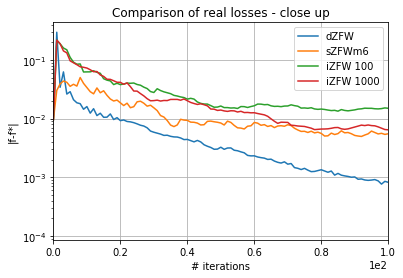

In [91]:
plt.plot(F_d)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,100))
plt.legend(('dZFW', "sZFWm6", "iZFW 100", "iZFW 1000"))
plt.grid()

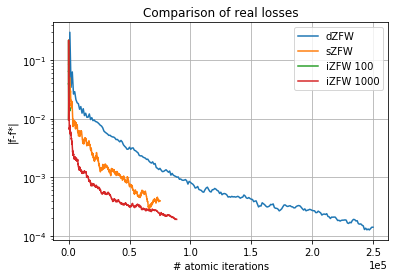

In [85]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW', 'iZFW 100','iZFW 1000'))
plt.grid()

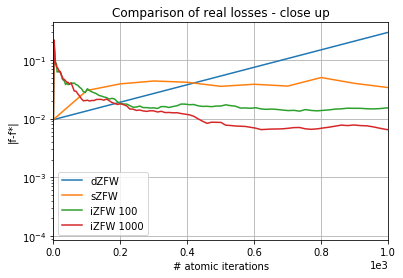

In [86]:
plt.plot(range(1, 251*d, d), f_valuesd - f_star)
plt.plot(range(0, 750*100+1, 100), f_valuess - f_star)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], F_i1000)
plt.title("Comparison of real losses - close up")
plt.yscale("log")
plt.xlim((0,1000))
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW', 'iZFW 100','iZFW 1000'))
plt.grid()